In [85]:
# essential packages
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import glob
import yaml
import numpy as np
import pandas as pd
import random

## Data Loader

In [86]:
file_name = "aisdk_20180101"
howmany=100
using_file_indices = np.arange(0,howmany)

In [87]:
df_entire_pass = pd.DataFrame()

# https://www.w3resource.com/pandas/dataframe/dataframe-to_pickle.php
for using_file_idx in using_file_indices:
    unpickled_df = pd.read_pickle("./dk_csv_20180101/aisdk_20180101_{}.pkl".format(str(using_file_idx)))
    unpickled_df
    df_entire_pass = pd.concat([df_entire_pass, unpickled_df])

In [88]:
df_entire_pass

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label
Timestamp,,,,,,,,,,,
2018-01-01 23:34:30,4.214136,2.391927,-0.009386,-0.006086,4.845643,0.516252,-0.001975,145.0,True,0,L
2018-01-01 23:34:45,4.086469,2.312937,-0.008511,-0.005266,4.695626,0.515043,-0.001209,145.5,True,0,L
2018-01-01 23:35:00,3.972708,2.235017,-0.007584,-0.005195,4.558257,0.512460,-0.002584,147.0,True,0,L
2018-01-01 23:35:15,3.857949,2.154808,-0.007651,-0.005347,4.418933,0.509374,-0.003086,150.5,True,0,L
2018-01-01 23:35:30,3.730337,2.078144,-0.008507,-0.005111,4.270140,0.508272,-0.001102,150.0,True,0,L
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:03:15,-0.262677,0.819739,-0.001342,0.003051,0.860797,1.880898,0.006422,72.0,True,99,L
2018-01-01 19:03:30,-0.282814,0.865512,-0.001342,0.003051,0.910546,1.886618,0.005720,72.0,True,99,L
2018-01-01 19:03:45,-0.297036,0.894617,-0.000948,0.001940,0.942640,1.891370,0.004752,72.0,True,99,L


### pre-processing

In [89]:
def convert_from_NED_to_Robotic(angle):

    """
    convert radian angle based on NED frame to radian angle based on the robotics frame
    """

    if 0 <= angle <= np.pi * 1/2:
        converted_angle = np.pi * 1/2 - angle
        return converted_angle

    elif np.pi * 1/2 < angle < np.pi * 3/2:
        converted_angle = - angle + np.pi * 1/2
        return converted_angle

    else: # 270 <= angle < 360
        converted_angle = (np.pi * 5/2) - angle
        return converted_angle

In [90]:
df_entire_pass['heading_converted']  = np.deg2rad(df_entire_pass['Heading'])
# lambda function method: very fast! 
# https://stackoverflow.com/questions/71249186/applying-function-to-column-in-a-dataframe
df_entire_pass['heading_converted'] = df_entire_pass['heading_converted'].apply(convert_from_NED_to_Robotic)


In [91]:
df_entire_pass

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label,heading_converted
Timestamp,,,,,,,,,,,,
2018-01-01 23:34:30,4.214136,2.391927,-0.009386,-0.006086,4.845643,0.516252,-0.001975,145.0,True,0,L,-0.959931
2018-01-01 23:34:45,4.086469,2.312937,-0.008511,-0.005266,4.695626,0.515043,-0.001209,145.5,True,0,L,-0.968658
2018-01-01 23:35:00,3.972708,2.235017,-0.007584,-0.005195,4.558257,0.512460,-0.002584,147.0,True,0,L,-0.994838
2018-01-01 23:35:15,3.857949,2.154808,-0.007651,-0.005347,4.418933,0.509374,-0.003086,150.5,True,0,L,-1.055924
2018-01-01 23:35:30,3.730337,2.078144,-0.008507,-0.005111,4.270140,0.508272,-0.001102,150.0,True,0,L,-1.047198
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:03:15,-0.262677,0.819739,-0.001342,0.003051,0.860797,1.880898,0.006422,72.0,True,99,L,0.314159
2018-01-01 19:03:30,-0.282814,0.865512,-0.001342,0.003051,0.910546,1.886618,0.005720,72.0,True,99,L,0.314159
2018-01-01 19:03:45,-0.297036,0.894617,-0.000948,0.001940,0.942640,1.891370,0.004752,72.0,True,99,L,0.314159


## Train, test data split

In [92]:
# https://www.geeksforgeeks.org/how-to-randomly-select-elements-of-an-array-with-numpy-in-python/

np.random.seed(0)


# for train, test data
use_df = df_entire_pass.loc[(df_entire_pass.valid == True)] # to be used, valid df
unique_id = use_df.obj_index.unique()

# data split
train_data_size = int(len(unique_id) * 0.8)
test_data_size = len(unique_id) - train_data_size
print("train size: {} \n test size: {}".format(train_data_size, test_data_size))

# split obj indexes
train_obj_id = np.random.choice(unique_id, size = train_data_size, replace=False)
test_obj_id = np.setdiff1d(unique_id, train_obj_id)
train_obj_id

train size: 80 
 test size: 20


array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29, 49, 97, 98, 69, 20, 94, 72, 77])

In [93]:
def get_trajectory_before_pass(df_input, obj_id_array):
    """
    Args:
        - df_input: data_frame for training or test

    Returns:
        - cropped dataframe with position only ahead for predicting the direction
    """
    df_cropped = pd.DataFrame()
    for idx, obj_id in enumerate(obj_id_array):
        # TODO backside too
        df_cropped = pd.concat([df_cropped, df_input.loc[(df_input['obj_index'] == obj_id) & \
                                                         (df_input['x'] > 0.0)]], ignore_index=True)
    return df_cropped

In [94]:
def check_dimension(x_data, y_data):
    if len(x_data) == len(y_data):
        print("Input, output dimension is same. good to go")
    else:
        raise ValueError("Input, output dimension is different. Double check!")

In [95]:
# train data
df_cropped_train = get_trajectory_before_pass(df_entire_pass, train_obj_id)
df_cropped_train

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label,heading_converted
0,4.698369,-1.403258,-0.009192,0.004104,4.903448,-0.290235,0.003865,210.0,True,26,L,-2.094395
1,4.565623,-1.343425,-0.008850,0.003989,4.759171,-0.286171,0.004064,210.0,True,26,L,-2.094395
2,4.422403,-1.278315,-0.009548,0.004341,4.603449,-0.281385,0.004786,210.0,True,26,L,-2.094395
3,4.279420,-1.213489,-0.009532,0.004322,4.448145,-0.276310,0.005074,210.0,True,26,L,-2.094395
4,4.138647,-1.151726,-0.009385,0.004118,4.295914,-0.271418,0.004892,210.0,True,26,L,-2.094395
...,...,...,...,...,...,...,...,...,...,...,...,...
10445,0.336464,0.919474,-0.004602,0.000695,0.979102,1.220000,0.068773,193.0,True,77,L,-1.797689
10446,0.262734,0.929513,-0.004915,0.000669,0.965931,1.295325,0.075325,193.0,True,77,L,-1.797689
10447,0.198039,0.939042,-0.004313,0.000635,0.959697,1.362947,0.067623,193.5,True,77,L,-1.806416
10448,0.129021,0.949109,-0.004601,0.000671,0.957838,1.435685,0.072738,194.0,True,77,L,-1.815142


In [96]:
np.all(df_cropped_train['label'])

True

In [97]:
np.any(np.isnan(df_cropped_train['y']))

False

In [98]:
# test data
df_cropped_test = get_trajectory_before_pass(df_entire_pass, test_obj_id)
df_cropped_test

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label,heading_converted
0,0.531333,4.889139,0.000172,-0.007141,4.917926,1.462545,-0.002815,90.625000,True,9,R,-0.010908
1,0.531943,4.777563,0.000041,-0.007438,4.807085,1.459911,-0.002634,90.937500,True,9,R,-0.016362
2,0.531469,4.642245,-0.000032,-0.009021,4.672568,1.456807,-0.003104,91.250000,True,9,R,-0.021817
3,0.534526,4.534370,0.000204,-0.007192,4.565767,1.453455,-0.003353,91.562500,True,9,R,-0.027271
4,0.537584,4.426495,0.000204,-0.007192,4.459020,1.449941,-0.003513,91.875000,True,9,R,-0.032725
...,...,...,...,...,...,...,...,...,...,...,...,...
5089,0.094810,-0.029229,0.000007,0.000066,0.099214,-0.299046,0.009800,97.163636,True,96,L,-0.125029
5090,0.096544,-0.029880,0.000116,-0.000043,0.101062,-0.300143,-0.001096,95.109091,True,96,L,-0.089170
5091,0.098277,-0.030530,0.000116,-0.000043,0.102910,-0.301199,-0.001057,93.054545,True,96,L,-0.053312
5092,0.100011,-0.031180,0.000116,-0.000043,0.104758,-0.302219,-0.001019,91.000000,True,96,L,-0.017453


## Train, test data onehot encoding and extract specific cell

In [99]:
# columns to extract
columns_for_x = ['x', 'y', 'rel_dist', 'rel_bearing', 'heading_converted']
# columns_for_x = ['r_value', 'atan']
columns_for_y = ['label']

# one hot encoding for y target
one_hot_lookup = torch.eye(2).tolist()

# df to array
X_train = []
X_test = []
y_train = []
y_test = []

#### train dataset
for obj_id, df_by_ID in df_cropped_train.groupby('obj_index'):
    X_train.append(df_by_ID[columns_for_x].values.tolist())
    # y_train.append(16one_hot_lookup[0] if df_by_ID[columns_for_y].values[-1][0] == "L" else one_hot_lookup[1]) # last row, only char
    y_train.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" else 1) # last row, only char

    #### double check train dataset
check_dimension(X_train, y_train)

#### test dataset
for obj_id, df_by_ID in df_cropped_test.groupby('obj_index'):
    X_test.append(df_by_ID[columns_for_x].values.tolist())
    # y_test.append(one_hot_lookup[0] if df_by_ID[columns_for_y].values[-1][0] == "L" else one_hot_lookup[1]) # last row, only char
    y_test.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" else 1) # last row, only char

#### double check test dataset
check_dimension(X_test, y_test)

# y_train

Input, output dimension is same. good to go
Input, output dimension is same. good to go


## RNN model

### Hyper parameters

In [100]:
# sequence_length = 10 # number of timestamps # padding
input_size = 5 # number of columns, features
batch_size = 32 # number of samples sent to the model at one time 32

hidden_size = 64 # dimension of hidden state # 500
num_layers = 10 # total layer
num_classes = 1 # output class (L or R)
num_epochs = 1000
learning_rate = 0.001
clip=1 # gradient clipping

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [101]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Convert sequences to PyTorch tensors
# sequences: List of variable-length sequences
# targets: List of target labels

def pad_sequential_data(X_data, y_data):
    """
    Args:
        X_data: (list) training or test X data, sequential, not equal length
        y_data: (list) training or test y data

    Returns:
        - same length sequence for X_data

    reference: https://chat.openai.com/c/235f65e4-3a26-4418-a88c-ecf521cc5d8d
    """
    sequences = [torch.tensor(seq) for seq in X_data]
    targets = torch.tensor(y_data)

    #### Sort sequences by length in descending order
    # sequences[i] indicatess i th object (variable length)
    # sequence[i][0] (dimension: feature numbers)

    # sorted_indices = sorted(range(len(sequences)), key=lambda i: len(sequences[i][0]), reverse=True)
    sorted_indices = sorted(range(len(sequences)), key=lambda i: len(sequences[i]), reverse=True)

    #### sorted as per length
    sequences = [sequences[i] for i in sorted_indices]
    targets = targets[sorted_indices]

    #### Pad the sequences to make them the same length (zero padding as default)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, targets

In [102]:
#### Create a TensorDataset from the padded sequences and targets
padded_sequences, targets = pad_sequential_data(X_train, y_train)
train_dataset = TensorDataset(padded_sequences, targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

padded_sequences_test, targets_test = pad_sequential_data(X_test, y_test)
test_dataset = TensorDataset(padded_sequences_test, targets_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

padded_sequences_test.size()

torch.Size([20, 3253, 5])

In [103]:
# padded_sequences

### RNN define and initialization

In [104]:
# # Create an RNN model
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         # https://discuss.pytorch.org/t/could-someone-explain-batch-first-true-in-lstm/15402/2
#         # self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.batch_norm = nn.BatchNorm1d(hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.sigmoid=nn.Sigmoid()

#     def forward(self, x):
#         ##### RNN
#         # _, hidden = self.rnn(x)
#         # output = self.fc(hidden.squeeze(0))
#         # return output


#         ##### LSTM
#         # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         h0 = torch.zeros(self.num_layers, x.data.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.data.size(0), self.hidden_size).to(device)

#         # Forward propagate LSTM
#         out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

#         # Decode the hidden state of the last time step
#         # out = self.batch_norm(out[:, -1, :])
#         # out = self.fc(out)
#         # // up to here batchnorm use

#         out = self.fc(out[:, -1, :])
#         out = self.sigmoid(out)
#         return out


In [105]:
# model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
# print(model)

# # Loss and optimizer
# # criterion = nn.CrossEntropyLoss()
# # criterion = nn.BCEWithLogitsLoss() ## using
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# import torch.optim as optim
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [106]:
# # train mode
# model.train()

# loss_history =torch.tensor([])
# for epoch in range(num_epochs):
#     for batch_sequences, batch_targets in train_loader:
#         # print(batch_sequences.size())
#         # print(batch_targets.size())
#         optimizer.zero_grad()

#         # 1) Pack the sequences before passing them to the RNN
#         # TODO do we really need this?
#         sequence_lengths = [len(seq) for seq in batch_sequences]
#         packed_sequences = pack_padded_sequence(batch_sequences, sequence_lengths, batch_first=True, enforce_sorted=False).to(device)

#         batch_sequences = batch_sequences.to(device)
#         batch_targets = batch_targets.to(device)

#         # 2) Forward pass
#         output = model(batch_sequences)
#         # output = model(packed_sequences)
#         # Compute the loss
#         loss = criterion(output.squeeze(), batch_targets.float())

#         # 3) Backward pass and optimization
#         loss.backward()

          # 4) Gradient clipping
#         # nn.utils.clip_grad_norm_(model.parameters(), clip)

#         optimizer.step()

#     loss_history = torch.cat([loss_history, torch.tensor([loss.item()]).float()], dim=0)

#     # Print the loss for every epoch
#     if epoch % 1 == 0:
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# #     scheduler.step()
# #     print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
# #     if epoch % 5 == 0:print()

In [109]:
# # sequence_length = 10 # number of timestamps # padding
# input_size = 5 # number of columns, features
# batch_size = 32 # number of samples sent to the model at one time

# hidden_size = 500 # dimension of hidden state
# num_layers = 10 # total layer
# num_classes = 1 # output class (L or R)
# num_epochs = 300
# learning_rate = 0.008
# clip=1 # gradient clipping

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

### LSTM 2D model with packed padding

In [110]:

class LSTM2D(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM2D, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        packed_sequences = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        packed_out, _ = self.lstm(packed_sequences, (h0, c0))
        
#         # Decode the hidden state of the last time step
#         # out = self.batch_norm(out[:, -1, :])
#         # out = self.fc(out)
#         # // up to here batchnorm use
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        out = out[:, -1, :]
#         out = self.batch_norm(out)
        out = self.fc(out)
        # https://stackoverflow.com/questions/66456541/runtimeerror-cuda-error-device-side-assert-triggered-on-loss-function
        out = self.sigmoid(out) # ouput [0, 1]
        
        return out


In [111]:
model = LSTM2D(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


LSTM2D(
  (lstm): LSTM(5, 64, num_layers=10, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [112]:
# Training loop
model.train()
loss_history =torch.tensor([])

for epoch in range(num_epochs):
    for batch_sequences, batch_labels in train_loader:
        optimizer.zero_grad()

        # 1) Calculate the sequence lengths for the current batch
        lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)

        batch_sequences = batch_sequences.to(device)
        batch_labels = batch_labels.to(device)
        
        # 2) Forward pass
        output = model(batch_sequences, lengths)
        
        # this is possible, but I did instead output squeeze to match dimension
        # batch_labels = torch.unsqueeze(batch_labels, 1)

        # 3) Compute the loss       
        loss = criterion(output.squeeze(), batch_labels.float())

        # 4) Backward pass and optimization
        loss.backward()
        
        # 5) Gradient Clipping
        # 5-1) Gradient Norm Clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        # 5-2) Gradient Value Clipping
        # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
       
        optimizer.step()

    loss_history = torch.cat([loss_history, torch.tensor([loss.item()]).float()], dim=0)
    #scheduler.step()
    # Print the loss for every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/1000, Loss: 0.7043993473052979
Epoch 2/1000, Loss: 0.7039151191711426
Epoch 3/1000, Loss: 0.7013883590698242
Epoch 4/1000, Loss: 0.700514554977417
Epoch 5/1000, Loss: 0.6987202167510986
Epoch 6/1000, Loss: 0.6958824992179871
Epoch 7/1000, Loss: 0.6951488256454468
Epoch 8/1000, Loss: 0.6938349008560181
Epoch 9/1000, Loss: 0.6919913291931152
Epoch 10/1000, Loss: 0.6892048120498657
Epoch 11/1000, Loss: 0.7044572830200195
Epoch 12/1000, Loss: 0.6867601275444031
Epoch 13/1000, Loss: 0.6845365762710571
Epoch 14/1000, Loss: 0.6808549165725708
Epoch 15/1000, Loss: 0.6783273220062256
Epoch 16/1000, Loss: 0.676868736743927
Epoch 17/1000, Loss: 0.6749128699302673
Epoch 18/1000, Loss: 0.7278903126716614
Epoch 19/1000, Loss: 0.6725388765335083
Epoch 20/1000, Loss: 0.7214378118515015
Epoch 21/1000, Loss: 0.7174361944198608
Epoch 22/1000, Loss: 0.6725666522979736
Epoch 23/1000, Loss: 0.6734480857849121
Epoch 24/1000, Loss: 0.6710433959960938
Epoch 25/1000, Loss: 0.6707892417907715
Epoch 26/10

Epoch 205/1000, Loss: 0.5474289655685425
Epoch 206/1000, Loss: 0.6148419380187988
Epoch 207/1000, Loss: 0.5463526248931885
Epoch 208/1000, Loss: 0.6235527992248535
Epoch 209/1000, Loss: 0.5452894568443298
Epoch 210/1000, Loss: 0.521877646446228
Epoch 211/1000, Loss: 0.5442463755607605
Epoch 212/1000, Loss: 0.5714670419692993
Epoch 213/1000, Loss: 0.5316013097763062
Epoch 214/1000, Loss: 0.5660117864608765
Epoch 215/1000, Loss: 0.5707005858421326
Epoch 216/1000, Loss: 0.5299090147018433
Epoch 217/1000, Loss: 0.5293529629707336
Epoch 218/1000, Loss: 0.5169225931167603
Epoch 219/1000, Loss: 0.5401463508605957
Epoch 220/1000, Loss: 0.5516031980514526
Epoch 221/1000, Loss: 0.5912490487098694
Epoch 222/1000, Loss: 0.5385971069335938
Epoch 223/1000, Loss: 0.562371015548706
Epoch 224/1000, Loss: 0.5619690418243408
Epoch 225/1000, Loss: 0.5248239040374756
Epoch 226/1000, Loss: 0.5242730379104614
Epoch 227/1000, Loss: 0.5237203240394592
Epoch 228/1000, Loss: 0.5196224451065063
Epoch 229/1000, Lo

Epoch 405/1000, Loss: 0.4385848045349121
Epoch 406/1000, Loss: 0.523872971534729
Epoch 407/1000, Loss: 0.48071548342704773
Epoch 408/1000, Loss: 0.4804120659828186
Epoch 409/1000, Loss: 0.4585484564304352
Epoch 410/1000, Loss: 0.47981852293014526
Epoch 411/1000, Loss: 0.4578625559806824
Epoch 412/1000, Loss: 0.46093112230300903
Epoch 413/1000, Loss: 0.4354279041290283
Epoch 414/1000, Loss: 0.478633850812912
Epoch 415/1000, Loss: 0.4564962387084961
Epoch 416/1000, Loss: 0.4780540466308594
Epoch 417/1000, Loss: 0.499705046415329
Epoch 418/1000, Loss: 0.45549875497817993
Epoch 419/1000, Loss: 0.5028398036956787
Epoch 420/1000, Loss: 0.4327566623687744
Epoch 421/1000, Loss: 0.49873974919319153
Epoch 422/1000, Loss: 0.5223097801208496
Epoch 423/1000, Loss: 0.43543297052383423
Epoch 424/1000, Loss: 0.479671835899353
Epoch 425/1000, Loss: 0.4571399390697479
Epoch 426/1000, Loss: 0.45683494210243225
Epoch 427/1000, Loss: 0.4341081380844116
Epoch 428/1000, Loss: 0.42974868416786194
Epoch 429/10

Epoch 604/1000, Loss: 0.433470219373703
Epoch 605/1000, Loss: 0.43327978253364563
Epoch 606/1000, Loss: 0.46331337094306946
Epoch 607/1000, Loss: 0.372374951839447
Epoch 608/1000, Loss: 0.46788427233695984
Epoch 609/1000, Loss: 0.40218955278396606
Epoch 610/1000, Loss: 0.4323505759239197
Epoch 611/1000, Loss: 0.4017390012741089
Epoch 612/1000, Loss: 0.3453066945075989
Epoch 613/1000, Loss: 0.3708004355430603
Epoch 614/1000, Loss: 0.40108251571655273
Epoch 615/1000, Loss: 0.43602800369262695
Epoch 616/1000, Loss: 0.4357999563217163
Epoch 617/1000, Loss: 0.36976587772369385
Epoch 618/1000, Loss: 0.400221586227417
Epoch 619/1000, Loss: 0.430752158164978
Epoch 620/1000, Loss: 0.4613608121871948
Epoch 621/1000, Loss: 0.36875981092453003
Epoch 622/1000, Loss: 0.3685121238231659
Epoch 623/1000, Loss: 0.3729151487350464
Epoch 624/1000, Loss: 0.49177086353302
Epoch 625/1000, Loss: 0.42972609400749207
Epoch 626/1000, Loss: 0.42956212162971497
Epoch 627/1000, Loss: 0.3983519971370697
Epoch 628/10

Epoch 803/1000, Loss: 0.32867395877838135
Epoch 804/1000, Loss: 0.2906751036643982
Epoch 805/1000, Loss: 0.4040016829967499
Epoch 806/1000, Loss: 0.4099205732345581
Epoch 807/1000, Loss: 0.2900124788284302
Epoch 808/1000, Loss: 0.47958219051361084
Epoch 809/1000, Loss: 0.29550808668136597
Epoch 810/1000, Loss: 0.40933847427368164
Epoch 811/1000, Loss: 0.3652583956718445
Epoch 812/1000, Loss: 0.4413169026374817
Epoch 813/1000, Loss: 0.4412418305873871
Epoch 814/1000, Loss: 0.44117221236228943
Epoch 815/1000, Loss: 0.3646899461746216
Epoch 816/1000, Loss: 0.32631927728652954
Epoch 817/1000, Loss: 0.4792463779449463
Epoch 818/1000, Loss: 0.40260016918182373
Epoch 819/1000, Loss: 0.40250545740127563
Epoch 820/1000, Loss: 0.364042729139328
Epoch 821/1000, Loss: 0.33167046308517456
Epoch 822/1000, Loss: 0.36377865076065063
Epoch 823/1000, Loss: 0.3251727223396301
Epoch 824/1000, Loss: 0.44050562381744385
Epoch 825/1000, Loss: 0.41706758737564087
Epoch 826/1000, Loss: 0.4403637945652008
Epoch

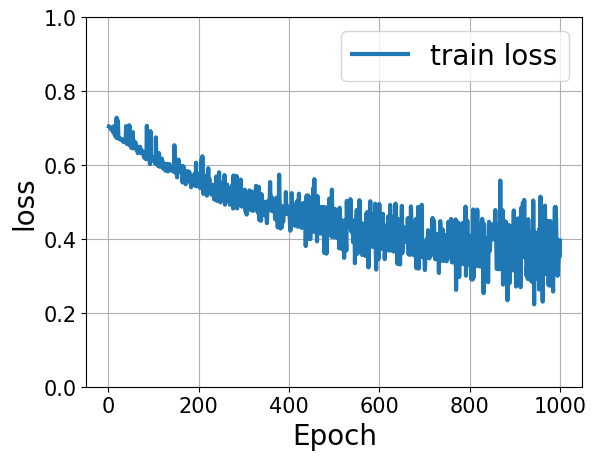

In [113]:
plt.figure()
plt.plot(range(1,num_epochs+1), loss_history, label = "train loss", linewidth=3)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 1)
plt.grid()

* __packed padding__: ok
    - resolving unreasonable overshooting
    - resolving the issue of zero padding and not knowing the original length
* __batch normalization__
    - so far overshooting
* __learning rate__
    - a bit large (0.001 -> 0.005) works better
* __layer and hidden size__: ok
    - not too much large, but larger one works well
* last batch dropout
    - works okay
* __gradient clipping__
* __gradient scheduler for decay__

Not yet applied
* dropout

In [114]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for batch_sequences, batch_targets in test_loader:
        # Data pre-processing
        lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)
        batch_sequences = batch_sequences.to(device)
        batch_targets = batch_targets.to(device)

        # Forward pass
        output = model(batch_sequences, lengths)
        total += batch_targets.size(0)      

        ### prediction
        pred = torch.round(output.squeeze())  # rounds to the nearest integer
        #_, predicted = torch.max(outputs, 1)
        
        correct_tensor = pred.eq(batch_targets.float().view_as(pred))
        current_correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        correct += np.sum(current_correct)
        
        y_true.extend(batch_targets.tolist())
        y_pred.extend(pred.tolist())

    print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))

    # Calculate other evaluation metrics (precision, recall, F1-score)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Test Accuracy of the model on the test data: 90.0 %
Precision: 0.9
Recall: 0.9
F1-score: 0.9


In [115]:
# https://discuss.pytorch.org/t/how-to-use-lstm-for-a-time-series-classification-task/130559/4